In [1]:
experiment_name= "cars_resnet18_hard_margin_p5"

In [2]:
import glob
import cv2

import matplotlib.pyplot as plt
%matplotlib inline
from pandas.core.common import flatten
import numpy as np
import random

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader

import datasets
import networks

##### Cars dataset downloaded from: https://www.kaggle.com/datasets/jutrera/stanford-car-dataset-by-classes-folder/code?resource=download
This version of the dataset already has all the images in the proper training and validation folders.

In [3]:
#######################################################
#                  Create Dataset
#######################################################
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = transforms.Compose([transforms.ToPILImage(),
                                transforms.Resize(256),
                                transforms.CenterCrop(256),
                                transforms.ToTensor()
                               ,
                              transforms.Normalize(mean, std)
                               ])

train_dataset = datasets.CarsDataset(transform, train=True)
test_dataset = datasets.CarsDataset(transform, train=False)

In [4]:
test_dataset.labels

array([  0,   0,   0, ..., 195, 195, 195])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


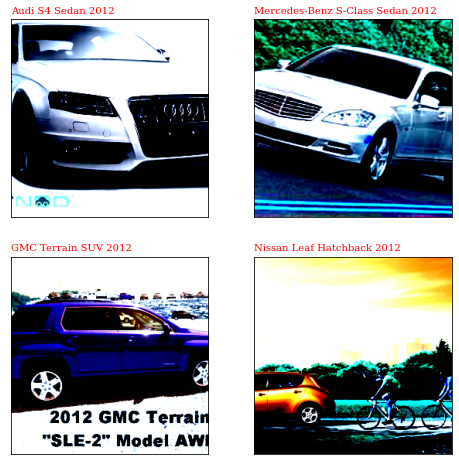

In [5]:
batch_size= 4
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Visualize some sample data
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(8, 8))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size//2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(train_loader.dataset.classes[labels[idx].item()], fontfamily='serif', loc='left', fontsize='medium', color= 'red')


In [6]:
# check if CUDA is available
cuda = torch.cuda.is_available()

if not cuda:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


# Online pair/triplet selection - negative mining
There are couple of problems with siamese and triplet networks.
1. The number of possible pairs/triplets grows **quadratically/cubically** with the number of examples. It's infeasible to process them all
2. We generate pairs/triplets randomly. As the training continues, more and more pairs/triplets are easy to deal with (their loss value is very small or even 0), preventing the network from training. We need to provide the network with **hard examples**.
3. Each image that is fed to the network is used only for computation of contrastive/triplet loss for only one pair/triplet. The computation is somewhat wasted; once the embedding is computed, it could be reused for many pairs/triplets.

To deal with that efficiently, we'll feed a network with standard mini-batches as we did for classification. The loss function will be responsible for selection of hard pairs and triplets within mini-batch. In these case, if we feed the network with 16 images per 10 classes, we can process up to $159*160/2 = 12720$ pairs and $10*16*15/2*(9*16) = 172800$ triplets, compared to 80 pairs and 53 triplets in previous implementation.

We can find some strategies on how to select triplets in [2] and [3] *Alexander Hermans, Lucas Beyer, Bastian Leibe, [In Defense of the Triplet Loss for Person Re-Identification](https://arxiv.org/pdf/1703.07737), 2017*

## Online triplet selection
## Steps
1. Create **BalancedBatchSampler** - samples $N$ classes and $M$ samples *datasets.py*
2. Create data loaders with the batch sampler
3. Define **embedding** *(mapping)* network $f(x)$ - **EmbeddingNet** from *networks.py*
4. Define a **TripletSelector** that takes embeddings and original labels and returns valid triplets within a minibatch
5. Define **OnlineTripletLoss** that will use a *TripletSelector* and compute *TripletLoss* on such pairs
6. Train the network!

In [7]:
train_dataset.labels

array([  0,   0,   0, ..., 195, 195, 195])

In [8]:
from datasets import BalancedBatchSampler

# A mini batch is created by sampling n_classes and n_samples from each class:
train_batch_sampler = BalancedBatchSampler(train_dataset.labels, n_classes=10, n_samples=25)
test_batch_sampler = BalancedBatchSampler(test_dataset.labels, n_classes=10, n_samples=25)

In [9]:
train_batch_sampler

In [10]:
online_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler)
online_test_loader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_batch_sampler)

In [11]:
online_train_loader

In [12]:
# Load the pretrained model from pytorch
embedding_net= torchvision.models.resnet18(pretrained=True)

# print out the model structure
#print(embedding_net)

/home/ayla/anaconda3/envs/fashion/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ayla/anaconda3/envs/fashion/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
# Un-Freeze training for all layers parameters:
for param in embedding_net.parameters():
    param.required_grad = True    

In [14]:
embedding_net.fc= nn.Sequential(nn.Linear(512, 128),
                                nn.BatchNorm1d(128),
                                nn.ReLU(),
                                nn.Linear(128, 128), # embedding size
                                )

In [15]:
# Un-Freeze training for all layers parameters:
for param in embedding_net.parameters():
    param.required_grad = True    

In [16]:
model= networks.TripletNet(embedding_net)

In [17]:
from losses import OnlineTripletLoss
# Strategies for selecting triplets within a minibatch:
from utils import AllTripletSelector,HardestNegativeTripletSelector, RandomNegativeTripletSelector, SemihardNegativeTripletSelector 

margin = 0.5
loss_fn = OnlineTripletLoss(margin, HardestNegativeTripletSelector(margin))

In [18]:
import torch.optim as optim
optimizer = optim.Adam(model.embedding_net.parameters(), lr=1e-3)

In [19]:
device = torch.device('cuda')
model.to(device)

TripletNet(
  (embedding_net): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

In [20]:
def train_epoch(train_loader, model, loss_fn, optimizer, log_interval, cuda):

    ###################
    # train the model #
    ###################
    model.train()

   # keep track of training loss
    train_loss = 0.0
    losses = []

    for batch_idx, (data, target) in enumerate(train_loader):
        
        target = target if len(target) > 0 else None
        if not type(data) in (tuple, list):
            data = (data,)
        
        # move tensors to GPU if CUDA is available
        if cuda:
            data = tuple(d.to(device) for d in data)
            if target is not None:
                target = tuple(t.to(device) for t in target)

        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        
        # forward pass: create embeddings of the inputs
        outputs = model.get_embedding(*data)

        if type(outputs) not in (tuple, list):
            outputs = (outputs,)

        loss_inputs = outputs
        if target is not None:
            target = (target,)
            loss_inputs += target

        # append targets to the end of the embeddings, and calculate the batch loss
        loss_outputs = loss_fn(*loss_inputs)
        
        loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
        
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        
        # perform a single optimization step (parameter update)
        optimizer.step()
        
        # update training loss
        train_loss += loss.item()

        losses.append(loss.item())
        
        # Provide some feedbach within one epoch
        if batch_idx % log_interval == 0:
            print('Train: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                batch_idx * len(data[0]), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), np.mean(losses)))
            losses = []

    # calculate average train loss (batch average is returned)
    train_loss /= (batch_idx + 1)
    
    return train_loss

In [21]:
def test_epoch(val_loader, model, loss_fn, cuda):
    
    ######################    
    # validate the model #
    ######################
    
    # keep track of validation loss
    valid_loss = 0.0
    
    with torch.no_grad():

        model.eval()
        for batch_idx, (data, target) in enumerate(val_loader):
            target = target if len(target) > 0 else None
            if not type(data) in (tuple, list):
                data = (data,)
            
            if cuda:
                data = tuple(d.to(device) for d in data)
                if target is not None:
                    target = tuple(t.to(device) for t in target)
            
            outputs = model.get_embedding(*data)

            if type(outputs) not in (tuple, list):
                outputs = (outputs,)
            loss_inputs = outputs
            if target is not None:
                target = (target,)
                loss_inputs += target

            loss_outputs = loss_fn(*loss_inputs)
            loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
            
            # update average validation loss 
            valid_loss += loss.item()
            
    # calculate average validation loss (batch average is returned)
    valid_loss /= (batch_idx + 1)

    return valid_loss

In [22]:
def save_model(EPOCH, model, optimizer, LOSS): # epoch and loss are numbers
    """
    Save the trained model and the optimizer to disk.
    """      
    torch.save({
                'epoch': EPOCH,
                'model_state_dict': model.embedding_net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': LOSS,
                }, experiment_name+'.pt')

In [23]:
start_epoch= 0
n_epochs= 50

log_interval=10

train_losses, valid_losses = [], []

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(start_epoch, n_epochs):
    
    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    train_loss = train_epoch(online_train_loader, model, loss_fn, optimizer, log_interval, cuda)
    valid_loss = test_epoch(online_test_loader, model, loss_fn, cuda)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(train_loss)
    print(valid_loss)
    # print training/validation statistics 
    print('Epoch: Epoch: {}/{} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch + 1, n_epochs, train_loss, valid_loss))
          
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format( valid_loss_min,
                                                                                          valid_loss))
        save_model(epoch, model, optimizer, train_loss)
        valid_loss_min = valid_loss
    

Train: [0/8144 (0%)]	Loss: 11.870965
Train: [2500/8144 (31%)]	Loss: 6.767829
Train: [5000/8144 (62%)]	Loss: 1.694929
Train: [7500/8144 (94%)]	Loss: 0.779218
3.279243154451251
1.051170950755477
Epoch: Epoch: 1/50 	Training Loss: 3.279243 	Validation Loss: 1.051171
Validation loss decreased (inf --> 1.051171).  Saving model ...
Train: [0/8144 (0%)]	Loss: 0.616816
Train: [2500/8144 (31%)]	Loss: 0.591076
Train: [5000/8144 (62%)]	Loss: 0.544840
Train: [7500/8144 (94%)]	Loss: 0.527888
0.5552603360265493
0.5243505127727985
Epoch: Epoch: 2/50 	Training Loss: 0.555260 	Validation Loss: 0.524351
Validation loss decreased (1.051171 --> 0.524351).  Saving model ...
Train: [0/8144 (0%)]	Loss: 0.518032
Train: [2500/8144 (31%)]	Loss: 0.520666
Train: [5000/8144 (62%)]	Loss: 0.511856
Train: [7500/8144 (94%)]	Loss: 0.509959
0.5140346772968769
0.5099389348179102
Epoch: Epoch: 3/50 	Training Loss: 0.514035 	Validation Loss: 0.509939
Validation loss decreased (0.524351 --> 0.509939).  Saving model ...
Trai

Train: [2500/8144 (31%)]	Loss: 0.501701
Train: [5000/8144 (62%)]	Loss: 0.502206
Train: [7500/8144 (94%)]	Loss: 0.501968
0.5019769743084908
0.5022662691771984
Epoch: Epoch: 29/50 	Training Loss: 0.501977 	Validation Loss: 0.502266
Train: [0/8144 (0%)]	Loss: 0.500182
Train: [2500/8144 (31%)]	Loss: 0.504802
Train: [4980/8144 (62%)]	Loss: 0.502608
Train: [7500/8144 (94%)]	Loss: 0.506280
0.5045535014942288
0.5063064154237509
Epoch: Epoch: 30/50 	Training Loss: 0.504554 	Validation Loss: 0.506306
Train: [0/8144 (0%)]	Loss: 0.488325
Train: [2500/8144 (31%)]	Loss: 0.514808
Train: [5000/8144 (62%)]	Loss: 0.507793
Train: [7500/8144 (94%)]	Loss: 0.507151
0.5090344753116369
0.5035242103040218
Epoch: Epoch: 31/50 	Training Loss: 0.509034 	Validation Loss: 0.503524
Train: [0/8144 (0%)]	Loss: 0.504511
Train: [2500/8144 (31%)]	Loss: 0.502966
Train: [5000/8144 (62%)]	Loss: 0.503039
Train: [7500/8144 (94%)]	Loss: 0.502279
0.5028056148439646
0.501433651894331
Epoch: Epoch: 32/50 	Training Loss: 0.502806 

In [24]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

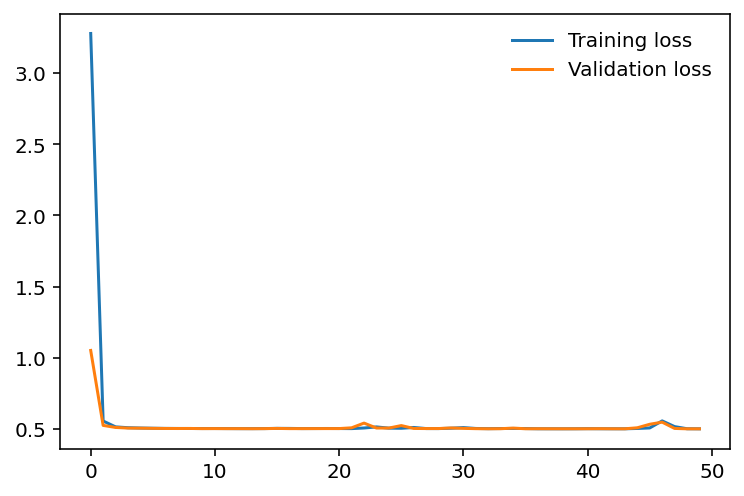

In [25]:
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False)

In [26]:
# write training results:
f = open(experiment_name+ "_result"+".csv", "w")
f.write('\t'.join(('tr_er', 'val_er')))
f.write('\n')
for (tr_er, val_er) in zip(train_losses, valid_losses,):
    items= (str(tr_er),',', str(val_er))
    f.write('\t'.join(items))
    f.write('\n')
f.close()

In [ ]:
# Load model and optimizer from disk:
embedding_net= torchvision.models.resnet18(pretrained=True)

# Freeze training for all layers parameters:
for param in embedding_net.parameters():
    param.required_grad = False    
    
embedding_net.fc= nn.Sequential(nn.Linear(512, 128),
                                nn.BatchNorm1d(128),
                                nn.ReLU(),
                                nn.Linear(128, 128), # embedding size
                                )

model= networks.TripletNet(embedding_net)

import torch.optim as optim
optimizer = optim.Adam(model.embedding_net.fc.parameters(), lr=1e-3)

PATH= experiment_name+'.pt'
check_point= torch.load(PATH)

model.embedding_net.load_state_dict(check_point['model_state_dict'])
optimizer.load_state_dict(check_point['optimizer_state_dict'])
epoch = check_point['epoch']
loss = check_point['loss']


In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()